In [10]:
import matplotlib.pyplot as plt
import torch
from train_fer import TimmClassifier
import pandas as pd
import timm

In [2]:
df = pd.read_csv("./fer2013.csv")
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.Usage.value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [18]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [15]:
# list_images = [get_image_from_pixels_list(pixels) for pixels in df.pixels]
with mp.Pool() as pool:
    list_images = pool.map(get_image_from_pixels_list, tqdm(df.pixels))

  0%|          | 0/35887 [00:00<?, ?it/s]

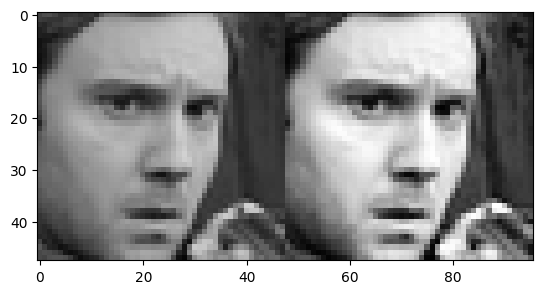

In [16]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2,2))
plt.imshow(np.hstack((list_images[0], clahe.apply(list_images[0]))), cmap="gray")

In [14]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model("mobilenetv4_hybrid_medium.e500_r224_in1k", pretrained=False, num_classes=0, in_chans=1)
        is_training = self.training
        self.backbone.eval()
        input_size = 128
        with torch.no_grad():
            num_ftrs = self.backbone(torch.randn(1, 1, input_size, input_size)).shape[-1]
        self.backbone.train(is_training)
        
        self.classifier = torch.nn.Sequential(
            torch.nn.ReLU(),
            torch.nn.Linear(num_ftrs, 7),
        )

    def forward(self, x):
        return self.classifier(self.backbone(x))

In [16]:
# model = TimmClassifier(
#     class_weights=torch.Tensor([1/7]*7),
# )

model = Model()
model.load_state_dict(
    torch.load(
        "/Users/mahamadou/Documents/PERSONAL/alkasalissou.tech/src/ml_model_training_scripts/output/output_mobilenetv4_hybrid_medium.e500_r224_in1k_2024-07-03_01-10-01/checkpoints/last.ckpt",
        map_location="cpu",
        )["state_dict"],
        strict=False
)
model.eval();

In [17]:
torch_input = torch.randn(1, 1, 128, 128)
onnx_program = torch.onnx.dynamo_export(model, torch_input)

/Users/mahamadou/venv3.9.19/lib/python3.9/site-packages/torch/onnx/_internal/exporter.py:136: UserWarning: torch.onnx.dynamo_export only implements opset version 18 for now. If you need to use a different opset version, please register them with register_custom_op.
  warnings.warn(
/Users/mahamadou/venv3.9.19/lib/python3.9/site-packages/torch/onnx/_internal/fx/passes/readability.py:53: UserWarning: Attempted to insert a get_attr Node with no underlying reference in the owning GraphModule! Call GraphModule.add_submodule to add the necessary submodule, GraphModule.add_parameter to add the necessary Parameter, or nn.Module.register_buffer to add the necessary buffer
  new_node = self.module.graph.get_attr(normalized_name)
/Users/mahamadou/venv3.9.19/lib/python3.9/site-packages/torch/fx/graph.py:1460: UserWarning: Node backbone_bn1_running_mean target backbone/bn1/running_mean backbone/bn1/running_mean of  does not reference an nn.Module, nn.Parameter, or buffer, which is what 'get_attr' N

In [19]:
onnx_program.save("/Users/mahamadou/Documents/PERSONAL/alkasalissou.tech/public/static/models/FER_mobilenetv4.onnx")

In [20]:
import onnxruntime

onnx_input = onnx_program.adapt_torch_inputs_to_onnx(torch_input)
print(f"Input length: {len(onnx_input)}")
print(f"Sample input: {onnx_input}")

ort_session = onnxruntime.InferenceSession("/Users/mahamadou/Documents/PERSONAL/alkasalissou.tech/public/static/models/FER_mobilenetv4.onnx",
                                            providers=['CPUExecutionProvider'])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

onnxruntime_input = {k.name: to_numpy(v) for k, v in zip(ort_session.get_inputs(), onnx_input)}

onnxruntime_outputs = ort_session.run(None, onnxruntime_input)

Input length: 1
Sample input: (tensor([[[[-2.4845, -0.0339,  0.4772,  ..., -0.1205,  0.5375,  0.2886],
          [-0.0425,  0.0278, -0.5095,  ..., -0.0870, -1.8772,  0.1392],
          [ 0.0434,  0.1258,  1.3014,  ..., -0.8646, -0.4593,  0.6184],
          ...,
          [-0.7025,  1.9285, -0.9759,  ..., -0.5705, -0.2145, -0.6220],
          [-0.2729, -1.9116, -0.4980,  ..., -0.3053, -1.7357,  0.0498],
          [ 2.4335,  2.0964, -0.4754,  ...,  0.2711,  0.1106, -0.4218]]]]),)


In [21]:
onnxruntime_outputs

[array([[ -8.86619  , -50.762165 ,  17.419815 ,  -1.2331553, -26.977152 ,
         -54.85634  , -37.12392  ]], dtype=float32)]